In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

PATH = os.path.join("datasets", "ps5")

def load_tweet_data(file, data_path=PATH):
    os.makedirs(data_path, exist_ok=True)
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path)

In [21]:
# Load csv file and investigate the data
tweets = load_tweet_data("ps5_tweets_text.csv")
labels = load_tweet_data("ps5_tweets_labels_as_numbers.csv")
labels.head()

,Id,Label
0,0,4
1,1,1
2,2,2
3,3,1
4,4,0


In [22]:
# Drop Id from labels as each has its own unique value
labels = labels.drop(["Id"], axis=1)

In [23]:
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions

nlp = spacy.load('en_core_web_sm')

# Exclude no and not from stopword list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

In [24]:
# Remove any extra html tags that appear
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [25]:
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

In [26]:
# Remove all accents so words are considered the same
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

In [27]:
# Change all contractions to two words
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [65]:
# Function to fully preprocess each Tweet and make it more regularized
def text_preprocessing(text):

    
    text = strip_html_tags(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    text = expand_contractions(text)
    text = text.lower()

    # Tokenise text
    doc = nlp(text) 

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text

        # Remove remaining stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # Remove punctuations, # and tags at people
        if (token.pos_ == 'PUNCT' or edit == '#' or '@' in edit) and flag == True: 
            flag = False
        # Remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        # Remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False
        # Convert number words to numeric numbers and regular words to their lemma
        if token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
        elif token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
            
        # Add wanted tokens and remove others 
        if edit != "" and len(edit) != 1 and flag == True:
            clean_text.append(edit)        
    return clean_text

In [66]:
# Function to prepare Tweet data to be vectorized
def listToString(s): 
    
    str1 = "" 
    for ele in s: 
        str1 += (ele + " ") 
    
    return str1 

In [67]:
stripped = []

# Call function to regularize Tweet data
for tweet in tweets['Tweet']:
    stripped.append(listToString(text_preprocessing(tweet)).strip())

stripped


Heartbreaking." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


['https://t.co/upjxfogqs8 gaisss read limit outside wash hand use hand sanitizer ready stock food',
 'today week lockdown lot confectionary store run stock see lockdown increase covid-19 community spread specially class city emergency supply chain need pla',
 'tuskys partner amref provide ground health education awareness supermarket branch kenya',
 'ur grocery shopping like regular person outsource work poor risk get coronavirus store not',
 'uk critical care nurse cry supermarket shelf panic buying https://t.co/hw5xbrvwig coronavirus coronavirusuk covid19',
 'make heart ache elderly not disease people want yo starve force day expose not bulk buy selfish b*****ds stopthepeak stayhome',
 'covid-19 wreck aluminium price input cost china a00 aluminium ingot price decline rmb570 alumina price rmb32 covid19 aluminium price china a00aluminium ingot aluminaprice coronavirus alcircle news',
 'february home price increase percent annual pre coronavirus world property journal global news center

In [68]:
from sklearn.model_selection import train_test_split

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(stripped, labels, random_state=1)

In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(max_features=1800, min_df=11, max_df=0.6)
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

In [275]:
from sklearn.naive_bayes import MultinomialNB

# Train the model using Naive Bayes and predict test set values
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tf, y_train.values.ravel())
predictions = naive_bayes.predict(X_test_tf)

In [276]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('Accuracy score: ', accuracy_score(y_test, predictions))

Accuracy score:  0.4692797754022244


In [243]:
from sklearn.feature_extraction.text import CountVectorizer
# Use CountVectorizer to create a sparse matrix on whether or not a Tweet contains a word
cv = CountVectorizer(max_features=1800, min_df=11, max_df=0.30)

# Fit the model and transform training and test data
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [245]:
# Investigate words appearing most frequently in Tweets
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words_df.head(10)

,0
covid,8111
price,6098
19,5927
store,5627
supermarket,5229
not,5023
food,4958
grocery,4600
people,3782
consumer,3568


In [294]:
from sklearn.naive_bayes import MultinomialNB

# Train the model using Naive Bayes and predict test set values
naive_bayes = MultinomialNB(alpha=.3)
naive_bayes.fit(X_train_cv, y_train.values.ravel())
predictions = naive_bayes.predict(X_test_cv)

In [295]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('Accuracy score: ', accuracy_score(y_test, predictions))

Accuracy score:  0.49206349206349204


In [248]:
# Observe ground truth vs predictions
print(y_test)
print(predictions)

       Label
29506      2
17794      2
26985      1
6235       0
21142      1
...      ...
10242      1
35015      0
33353      2
18631      4
5632       3

[9261 rows x 1 columns]
[2 3 3 ... 3 1 4]


Text(32.99999999999999, 0.5, 'true label')

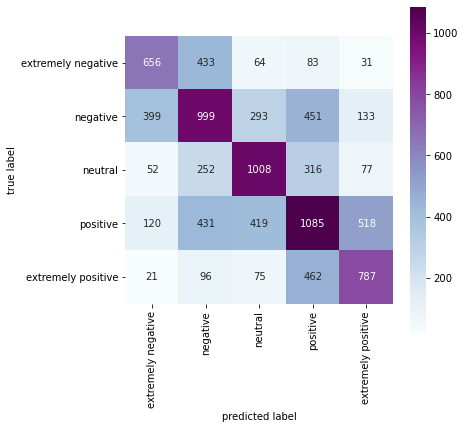

In [249]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

# Create a confusion matrix in order to visualize results and see where faults appear
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='BuPu',
xticklabels=['extremely negative', 'negative', 'neutral', 'positive', 'extremely positive'], yticklabels=['extremely negative', 'negative', 'neutral', 'positive', 'extremely positive'], ax=ax, fmt='g')
plt.xlabel('predicted label')
plt.ylabel('true label')